# Converting too and from ASTs using TranX

In [166]:
import ast
import sys
sys.path.insert(0,"src/external_repos/tranX")
from asdl.asdl import ASDLGrammar
from asdl.lang.py.py_asdl_helper import *
from asdl.lang.py3.py3_transition_system import *
from asdl.hypothesis import *
import astor
import copy

In [62]:
asdl_text = open('src/external_repos/tranX/asdl/lang/py3/py3_asdl.txt').read()
grammar = ASDLGrammar.from_text(asdl_text)

py_code = """
def fun():
    print(a)
print("foo_bar")
"""

# get the (domain-specific) python AST of the example Python code snippet
py_ast = ast.parse(py_code)

# convert the python AST into general-purpose ASDL AST used by tranX
asdl_ast = python_ast_to_asdl_ast(py_ast, grammar)
print('String representation of the ASDL AST: \n%s' % asdl_ast.to_string())
print('Size of the AST: %d' % asdl_ast.size)

# we can also convert the ASDL AST back into Python AST
py_ast_reconstructed = asdl_ast_to_python_ast(asdl_ast, grammar)

# initialize the Python transition parser
parser = Python3TransitionSystem(grammar)

# get the sequence of gold-standard actions to construct the ASDL AST
actions = parser.get_actions(asdl_ast)

# a hypothesis is an (partial) ASDL AST generated using a sequence of tree-construction actions
hypothesis = Hypothesis()
for t, action in enumerate(actions, 1):
    # the type of the action should belong to one of the valid continuing types
    # of the transition system
    assert action.__class__ in parser.get_valid_continuation_types(hypothesis)

    # if it's an ApplyRule action, the production rule should belong to the
    # set of rules with the same LHS type as the current rule
    if isinstance(action, ApplyRuleAction) and hypothesis.frontier_node:
        assert action.production in grammar[hypothesis.frontier_field.type]

    print('t=%d, Action=%s' % (t, action))
    hypothesis.apply_action(action)

# get the surface code snippets from the original Python AST,
# the reconstructed AST and the AST generated using actions
# they should be the same
src1 = astor.to_source(py_ast).strip()
src2 = astor.to_source(py_ast_reconstructed).strip()
src3 = astor.to_source(asdl_ast_to_python_ast(hypothesis.tree, grammar)).strip()

print(src1)
print(src2)
print(src3)
# assert src1 == src2 == src3 == "6 + 4"

String representation of the ASDL AST: 
(Module (stmt*-body (FunctionDef (identifier-name fun) (arguments-args (arguments (arg*-args) (arg?-vararg) (arg*-kwonlyargs) (expr*-kw_defaults) (arg?-kwarg) (expr*-defaults))) (stmt*-body (Expr (expr-value (Call (expr-func (Name (identifier-id print) (expr_context-ctx (Load)))) (expr*-args (Name (identifier-id a) (expr_context-ctx (Load)))) (keyword*-keywords))))) (expr*-decorator_list) (expr?-returns)) (Expr (expr-value (Call (expr-func (Name (identifier-id print) (expr_context-ctx (Load)))) (expr*-args (Str (string-s foo_bar))) (keyword*-keywords))))))
Size of the AST: 19
t=1, Action=ApplyRule[mod -> Module(stmt* body)]
t=2, Action=ApplyRule[stmt -> FunctionDef(identifier name, arguments args, stmt* body, expr* decorator_list, expr? returns)]
t=3, Action=GenToken[fun]
t=4, Action=ApplyRule[arguments -> arguments(arg* args, arg? vararg, arg* kwonlyargs, expr* kw_defaults, arg? kwarg, expr* defaults)]
t=5, Action=Reduce
t=6, Action=Reduce
t=7, 

In [64]:
py_ast.body[0].args.args

[]

In [48]:
def visit(node):
    fields = node._fields
    print(list(fields))
    for field in fields:
        attr = getattr(node, field)
        print(attr)
        visit(attr)
    
visit(py_ast)

['body']
[<_ast.FunctionDef object at 0x7f7ba1237c18>, <_ast.Expr object at 0x7f7ba1237a58>]


AttributeError: 'list' object has no attribute '_fields'

## modifying a tree into various sequences
#### Full code

In [109]:
py_code = """
def fun(a=5, b=5):
    print(a)
print("foo_bar")
"""

In [110]:
py_ast = ast.parse(py_code)
asdl_ast = python_ast_to_asdl_ast(py_ast, grammar)
actions = parser.get_actions(asdl_ast)
hypothesis = Hypothesis()
for t, action in enumerate(actions, 1):
    assert action.__class__ in parser.get_valid_continuation_types(hypothesis)
    if isinstance(action, ApplyRuleAction) and hypothesis.frontier_node:
        assert action.production in grammar[hypothesis.frontier_field.type]
    hypothesis.apply_action(action)

print("Full reconstructed code:")
print(astor.to_source(asdl_ast_to_python_ast(hypothesis.tree, grammar)).strip())

Full reconstructed code:
def fun(a=5, b=5):
    print(a)


print('foo_bar')


#### Modifying the Python AST to remove a particular section
We will set the amount of arguments to none

In [111]:
missing_sub_tree = copy.deepcopy(py_ast.body[0].args)
py_ast.body[0].args.args = []

In [112]:
missing_sub_tree.args

[<_ast.arg at 0x7f7ba08e4780>, <_ast.arg at 0x7f7ba08e49b0>]

In [113]:
asdl_ast = python_ast_to_asdl_ast(py_ast, grammar)
actions = parser.get_actions(asdl_ast)
hypothesis = Hypothesis()
for t, action in enumerate(actions, 1):
    assert action.__class__ in parser.get_valid_continuation_types(hypothesis)
    if isinstance(action, ApplyRuleAction) and hypothesis.frontier_node:
        assert action.production in grammar[hypothesis.frontier_field.type]
    hypothesis.apply_action(action)

print("Full reconstructed code:")
print(astor.to_source(asdl_ast_to_python_ast(hypothesis.tree, grammar)).strip())

Full reconstructed code:
def fun():
    print(a)


print('foo_bar')


The arguments are visualised here

In [114]:
asdl_ast = python_ast_to_asdl_ast(missing_sub_tree, grammar)
missing_actions = parser.get_actions(asdl_ast)
hypothesis = Hypothesis()
for t, action in enumerate(missing_actions, 1):
    assert action.__class__ in parser.get_valid_continuation_types(hypothesis)
    if isinstance(action, ApplyRuleAction) and hypothesis.frontier_node:
        assert action.production in grammar[hypothesis.frontier_field.type]
    hypothesis.apply_action(action)

print("Full reconstructed code:")
print(astor.to_source(asdl_ast_to_python_ast(hypothesis.tree, grammar)).strip())

Full reconstructed code:
a=5, b=5


In [115]:
actions

[ApplyRule[mod -> Module(stmt* body)],
 ApplyRule[stmt -> FunctionDef(identifier name, arguments args, stmt* body, expr* decorator_list, expr? returns)],
 GenToken[fun],
 ApplyRule[arguments -> arguments(arg* args, arg? vararg, arg* kwonlyargs, expr* kw_defaults, arg? kwarg, expr* defaults)],
 Reduce,
 Reduce,
 Reduce,
 Reduce,
 Reduce,
 ApplyRule[expr -> Num(object n)],
 GenToken[5],
 ApplyRule[expr -> Num(object n)],
 GenToken[5],
 Reduce,
 ApplyRule[stmt -> Expr(expr value)],
 ApplyRule[expr -> Call(expr func, expr* args, keyword* keywords)],
 ApplyRule[expr -> Name(identifier id, expr_context ctx)],
 GenToken[print],
 ApplyRule[expr_context -> Load()],
 ApplyRule[expr -> Name(identifier id, expr_context ctx)],
 GenToken[a],
 ApplyRule[expr_context -> Load()],
 Reduce,
 Reduce,
 Reduce,
 Reduce,
 Reduce,
 ApplyRule[stmt -> Expr(expr value)],
 ApplyRule[expr -> Call(expr func, expr* args, keyword* keywords)],
 ApplyRule[expr -> Name(identifier id, expr_context ctx)],
 GenToken[print]

In [116]:
missing_actions

[ApplyRule[arguments -> arguments(arg* args, arg? vararg, arg* kwonlyargs, expr* kw_defaults, arg? kwarg, expr* defaults)],
 ApplyRule[arg -> arg(identifier arg, expr? annotation)],
 GenToken[a],
 Reduce,
 ApplyRule[arg -> arg(identifier arg, expr? annotation)],
 GenToken[b],
 Reduce,
 Reduce,
 Reduce,
 Reduce,
 Reduce,
 Reduce,
 ApplyRule[expr -> Num(object n)],
 GenToken[5],
 ApplyRule[expr -> Num(object n)],
 GenToken[5],
 Reduce]

In [18]:
from anytree import Node, RenderTree, AsciiStyle, find_by_attr
f = Node("f")
b = Node("b", parent=f, foo=None)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'production']

In [17]:
actions[2].token

'r'

# using ANTLR

```bash
$ sudo apt-get install -y antlr4
$ pip install antlr4-python3-runtime
$ wget https://github.com/antlr/grammars-v4/blob/master/python/python3/Python3.g4
$ antlr4 -Dlanguage=Python3 Python3.g4
```

```python
import sys
from antlr4 import *
from MyGrammarLexer import MyGrammarLexer
from MyGrammarParser import MyGrammarParser
 
def main(argv):
    input_stream = FileStream(argv[1])
    lexer = MyGrammarLexer(input_stream)
    stream = CommonTokenStream(lexer)
    parser = MyGrammarParser(stream)
    tree = parser.startRule()
 
if __name__ == '__main__':
    main(sys.argv)
```

In [2]:
import sys
sys.path.insert(0,"src/ANTLR/")
from antlr4 import *
from src.ANTLR.Python3Lexer import Python3Lexer
from src.ANTLR.Python3Parser import Python3Parser
from src.ANTLR.Python3Listener import Python3Listener

input_stream = FileStream("test.py")
lexer = Python3Lexer(input_stream)
stream = CommonTokenStream(lexer)
parser = Python3Parser(stream)
tree = parser.file_input()

ANTLR runtime and generated code versions disagree: 4.8!=4.7
ANTLR runtime and generated code versions disagree: 4.8!=4.7.2


NameError: name 'Python3Parser' is not defined

# Using Tree Sitter

In [211]:
from tree_sitter import Language, Parser, Node

In [7]:
Language.build_library(
  # Store the library in the `build` directory
  'build/my-languages.so',

  # Include one or more languages
  [
    'src/tree-sitter/tree-sitter-javascript',
    'src/tree-sitter/tree-sitter-python'
  ]
)

False

In [8]:
JS_LANGUAGE = Language('build/my-languages.so', 'javascript')
PY_LANGUAGE = Language('build/my-languages.so', 'python')

In [21]:
parser = Parser()
parser.set_language(PY_LANGUAGE)

In [22]:
def sub_str_from_coords(string, start, end):
    lines = string.split("\n")
    s_line, s_char = start
    e_line, e_char = end
    assert s_line == e_line
    return lines[s_line][s_char:e_char]

In [23]:
js_str = """
function myFunction(p1, p2) {
    console.log.log("foo");
    return p1 * p2;
}
"""

In [176]:
code_str = """
from bar import foo
def foo(a=5):
    b=4
    if bar:
        baz()
        qux()
"""

tree = parser.parse(bytes(code_str, "utf8"))

In [170]:
def visit_node(node, indent_carry=""):
    if node.type in ["property_identifier","identifier", "string"]:
        print(indent_carry, sub_str_from_coords(code_str, node.start_point, node.end_point), end=' ')
    elif not node.is_named:
        print(indent_carry, node.type, end=' ')
    else:
        if node.type in ["block", 'statement_block']:
            print()
            indent_carry = indent_carry + ""
        elif node.type in ["expression_statement","return_statement"]:
            print()
            indent_carry = ""
    for child in node.children:
        visit_node(child,indent_carry)

In [171]:
visit_node(tree.root_node)

 from  bar  import  foo  def  foo  (  a  =  )  : 
 if  bar  : 

 baz  (  ) 
 qux  (  ) 

In [172]:
tree.root_node.children[0].children[3].children[1].children[0].children[1].children[1].children

IndexError: list index out of range

In [152]:
tree.root_node.children[0].children[3].children[1].children[0].children[1].children[1].children

[<Node kind=""", start_point=(2, 20), end_point=(2, 21)>,
 <Node kind=""", start_point=(2, 24), end_point=(2, 25)>]

In [35]:
tree.root_node.children[0].children[1]

<Node kind=identifier, start_point=(1, 4), end_point=(1, 7)>

In [185]:
tree.root_node.children[1].children[4].children[0].children[0].children

[<Node kind=expression_list, start_point=(3, 4), end_point=(3, 5)>,
 <Node kind="=", start_point=(3, 5), end_point=(3, 6)>,
 <Node kind=expression_list, start_point=(3, 6), end_point=(3, 7)>]

# Getting the grammar from Tree-Sitter
Tree-Sitter has this amazing file that is the `grammar.json` file in `tree-sitter-python/src/` it basically has all the information for the nodes and transitions I need.

In [1]:
import json
from anytree import NodeMixin, RenderTree
from pyformlang.finite_automaton import EpsilonNFA, State, Symbol, Epsilon
import networkx as nx
import matplotlib.pyplot as plt
from io import BytesIO
import matplotlib.image as mpimg
from IPython.display import Image, display

with open("src/tree-sitter/tree-sitter-python/src/grammar.json", "r") as grammar_file:
    python_grammar = json.load(grammar_file)


In [2]:
types = list(python_grammar["rules"].keys())
print(types)
print(len(types))

['module', '_statement', '_simple_statements', '_simple_statement', 'import_statement', 'import_prefix', 'relative_import', 'future_import_statement', 'import_from_statement', '_import_list', 'aliased_import', 'wildcard_import', 'print_statement', 'chevron', 'assert_statement', 'expression_statement', 'named_expression', 'return_statement', 'delete_statement', 'raise_statement', 'pass_statement', 'break_statement', 'continue_statement', '_compound_statement', 'if_statement', 'elif_clause', 'else_clause', 'for_statement', 'while_statement', 'try_statement', 'except_clause', 'finally_clause', 'with_statement', 'with_item', 'function_definition', 'parameters', 'lambda_parameters', '_parameters', '_parameter', 'default_parameter', 'typed_default_parameter', 'list_splat', 'dictionary_splat', 'global_statement', 'nonlocal_statement', 'exec_statement', 'class_definition', 'parenthesized_list_splat', 'argument_list', 'decorated_definition', 'decorator', '_suite', 'block', 'variables', 'express

In [3]:
python_grammar["rules"]["elif_clause"]

{'type': 'SEQ',
 'members': [{'type': 'STRING', 'value': 'elif'},
  {'type': 'FIELD',
   'name': 'condition',
   'content': {'type': 'SYMBOL', 'name': '_expression'}},
  {'type': 'STRING', 'value': ':'},
  {'type': 'FIELD',
   'name': 'consequence',
   'content': {'type': 'SYMBOL', 'name': '_suite'}}]}

In [4]:
python_grammar["rules"]["_suite"]

{'type': 'CHOICE',
 'members': [{'type': 'ALIAS',
   'content': {'type': 'SYMBOL', 'name': '_simple_statements'},
   'named': True,
   'value': 'block'},
  {'type': 'SEQ',
   'members': [{'type': 'SYMBOL', 'name': '_indent'},
    {'type': 'SYMBOL', 'name': 'block'}]}]}

In [5]:
python_grammar["rules"]["block"]

{'type': 'SEQ',
 'members': [{'type': 'REPEAT',
   'content': {'type': 'SYMBOL', 'name': '_statement'}},
  {'type': 'SYMBOL', 'name': '_dedent'}]}

In [6]:
class TreeNode(NodeMixin):
    def __init__(self, node_name, grammar):
        if node_name not in grammar["rules"]:
            raise Exception("Node not recognised")
        self.name = node_name
        self.member = grammar["rules"][node_name]
        self.children = []
        
    @property
    def node_complete(self):
        return len(children) == len(members)
    
    def get_first_symbols(self, member, member_in_case_BLANK=None):
        if member == None:
            return set()
        elif member["type"] == "SYMBOL":
            return set([member["name"]])
        elif member["type"] == "STRING":
            return set([member["value"]])
        elif member["type"] == "SEQ":
            return self.get_first_symbols(member["members"][0])
        elif member["type"] in ["REPEAT","REPEAT1","FIELD","PREC","PREC_LEFT","PREC_RIGHT"]:
            return self.get_first_symbols(member["content"]) 
        elif member["type"] == "CHOICE":
            choices = set()
            for choice in member["members"]:
                choices.update(self.get_first_symbols(choice))
            return choices
        
        return []
    
    def BLANK_possible(self, member):
        if member["type"] == "BLANK":
            return True
        elif member["type"] == "CHOICE":
            for CHOICE_member in member["members"]:
                if self.BLANK_possible(CHOICE_member):
                    return True
        elif member["type"] == "REPEAT":
            return True
        elif member["type"] == "REPEAT1":
            if self.BLANK_possible(member["content"]):
                return True
        return False
    
    """##### Doodle area
    
    node_sequence -> ['(']
    -> False, ["_parameters", ")"]
    cursor = 0
    
    node_sequence -> ['(', "foo"]
    -> False, []
    
    #######
    """
    def walk_member(self, node_sequence, member):
        sequence_cursor = 0
        if member["type"] == "SEQ":
            last_member_expansion_nodes = set()
            for SEQ_member in member["members"]:
                is_match, expansion_nodes, new_cursor = self.walk_member(node_sequence[sequence_cursor:], SEQ_member)
                sequence_cursor += new_cursor
                last_member_expansion_nodes.update(expansion_nodes)
                if is_match == False:
                    # the node doesn't match, could be because it's wrong or None
                    if sequence_cursor != len(node_sequence):
                        return False, set(), sequence_cursor
                    return False, last_member_expansion_nodes, sequence_cursor
                else:
                    if new_cursor != 0:
                        last_member_expansion_nodes = expansion_nodes
            if sequence_cursor != len(node_sequence):
                return False, set(), sequence_cursor            
            return True, last_member_expansion_nodes, sequence_cursor
        
        if member["type"] == "CHOICE":
            if sequence_cursor == len(node_sequence):
                # if BLANK is possible, the node_sequence is still valid
                return self.BLANK_possible(member), self.get_first_symbols(member), 0
            else:
                best_cursor = 0
                for CHOICE_member in member["members"]:
                    is_match, expansion_nodes, new_cursor = self.walk_member(node_sequence[sequence_cursor:], CHOICE_member)
                    best_cursor = max(best_cursor, new_cursor)
                    if is_match:
                        break
                if is_match:
                    if new_cursor == 0:
                        # case if BLANK
                        return True, self.get_first_symbols(member), best_cursor
                    else:
                        return True, expansion_nodes, new_cursor
                else:
                    return False, set(), 0
                
        if member["type"] == "REPEAT":
            if sequence_cursor == len(node_sequence):
                # if BLANK is possible, the node_sequence is still valid
                return True, self.get_first_symbols(member), 0
            else:
                is_match = True
                while is_match:
                    is_match, expansion_nodes, new_cursor = self.walk_member(node_sequence[sequence_cursor:], member["content"])
                    if new_cursor != 0:
                        #movement
                        sequence_cursor += new_cursor
                if sequence_cursor != len(node_sequence):
                    return False, set(), sequence_cursor  # this might be wrong
                else:
                    return True, expansion_nodes, sequence_cursor
                
        if member["type"] == "REPEAT1":
            if sequence_cursor == len(node_sequence):
                # if BLANK is possible, the node_sequence is still valid
                return False, self.get_first_symbols(member), 0
            else:
                is_match, expansion_nodes, new_cursor = self.walk_member(node_sequence[sequence_cursor:], member["content"])
                if not is_match:
                    return False, expansion_nodes, 0
                else:
                    sequence_cursor += new_cursor
                    is_match = True
                    while is_match:
                        is_match, expansion_nodes, new_cursor = self.walk_member(node_sequence[sequence_cursor:], member["content"])
                        if new_cursor != 0:
                            #movement
                            sequence_cursor += new_cursor
                    if sequence_cursor != len(node_sequence):
                        return False, set(), sequence_cursor  
                    else:
                        return True, expansion_nodes, sequence_cursor
        if member["type"] == "FIELD":
            is_match, expansion_nodes, new_cursor = self.walk_member(node_sequence[sequence_cursor:], member["content"])
            return is_match, expansion_nodes, new_cursor
        
        if member["type"] == "STRING":
            if sequence_cursor == len(node_sequence):
                # equivalent to if the node sequence is empty
                # no node available
                return False, set([member["value"]]), 0
            else:
                if node_sequence[sequence_cursor] == member["value"]:
                    return True, set(), 1
                else:
                    return False, set(), 0
        
        if member["type"] == "SYMBOL":
            if sequence_cursor == len(node_sequence):
                # no node available
                return False, set([member["name"]]), 0
            else:
                if node_sequence[sequence_cursor] == member["name"]:
                    return True, set(), 1
                else:
                    return False, set(), 0
                
        if member["type"] == "BLANK":
            return True, set(), 0
        
                
    def validate_sequence(self, node_sequence, member):
        if member["type"] == "SEQ":
            for i in range(max(len(node_sequence)), len(member["members"])):
                pass
        if member["type"] == "REPEAT":
            ignore
        if len(node_sequence) == 0:
            self.get_next_symbols(member)
        else:
            last_node = node_sequence[0]
            if member["type"] == "SEQ":
                pass
    
    def get_sub_member_rules(self, node_sequence, member):
        if len(node_sequence) == 0:
            self.get_next_symbols(member)
        else:
            last_node = node_sequence[0]
            if member["type"] == "SEQ":
                pass
            
    
    def next_child_type(self):
        pass

In [7]:
node = TreeNode("_simple_statements", python_grammar)

In [8]:
node.get_first_symbols(node.member)

{'_simple_statement'}

In [9]:
node.walk_member(["_simple_statement","_semicolon","_semicolon", "_newline"],node.member)

(True, set(), 4)

In [10]:
from typing import Iterable

class Custom_Symbol(Symbol):
    def __init__(self,name, extra="None"):
        super().__init__(name)
        self.extra = extra
        
class Custom_State(State):
    def __init__(self,name, extra="None"):
        super().__init__(name)
        self.extra = extra

def to_symbol(given):
    """ Transforms the input into a symbol
    Parameters
    ----------
    given : any
        What we want to transform
    """
    if isinstance(given, Symbol):
        return given
    if given == "epsilon":
        return Epsilon()
    return Symbol(given)   

punct_dict = {",":"COMMA"}

class Custom_ENFA(EpsilonNFA):
    def __init__(self):
        import networkx as nx
        import matplotlib.pyplot as plt
        super().__init__()
        
    def accepts_and_states(self, word):
#         word = [to_symbol(x) for x in word]
        current_states = self._start_state
        for symbol in word:
            current_states = self._get_next_states_iterable(current_states,
                                                            symbol)
        return any([self.is_final_state(x) for x in current_states]), current_states
    
    def plot(self):
        import networkx as nx
        graph = self.to_networkx()
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos)
        nx.draw_networkx_edge_labels(graph,pos)
        nx.draw_networkx_labels(graph,pos)
        
    def plot_dot(self):
        graph = self.to_networkx()
        for edge in graph.edges.data():
            try:
                if edge[2]["label"] in punct_dict:
                    edge[2]["label"] = punct_dict[edge[2]["label"]]
            except:
                pass
        graph.update(graph.edges, None)
        pdot = nx.drawing.nx_pydot.to_pydot(graph)
        png_str = pdot.write_png("/tmp/graph.png")
        display(Image(filename='/tmp/graph.png'))

In [11]:
epsilon = Epsilon()
bar = Symbol("bar")
baz = Symbol("baz")
foo = Symbol("foo")
states = [State("START"),State("bar"),State("baz"),State("MATCH")]

# Creattion of the Epsilon NFA
enfa = Custom_ENFA()
enfa.add_start_state(states[0])
enfa.add_final_state(states[3])
enfa.add_transition(states[0], epsilon, states[1])
enfa.add_transition(states[0], epsilon, states[2])

enfa.add_transition(states[1], bar, states[3])
enfa.add_transition(states[2], baz, states[3])
enfa.add_transition(states[2], foo, states[2])


# Checks if a word is accepted
val = [bar]
enfa.accepts(val)

True

In [338]:
enfa.to_networkx().

SyntaxError: invalid syntax (<ipython-input-338-2fe4211bc6ff>, line 1)

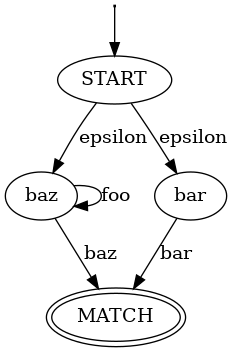

In [339]:
enfa.plot_dot()

In [340]:
enfa._transition_function._transitions[states[2]]

{baz: {MATCH}, foo: {baz}}

In [16]:
externals = [x["name"] for x in python_grammar["externals"]]

In [26]:
444_3

4443

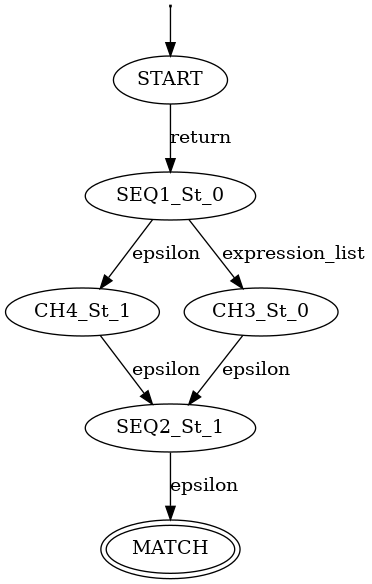

In [40]:
prefix = 0
def add_transitions(member, NFA, enter_state, exit_state):
    global prefix
    prefix += 1
    
    if member["type"] == "BLANK":
        NFA.add_transition(enter_state, Epsilon(), exit_state)
    
    if member["type"] == "SYMBOL":
        if member["name"][0] == "_" and member["name"] not in externals:
            add_transitions(node_types[member["name"]], NFA, enter_state, exit_state)
        else:
            symbol = Symbol(member["name"])
            NFA.add_transition(enter_state, symbol, exit_state)
    
    if member["type"] == "STRING":
        symbol = Symbol(member["value"])
        NFA.add_transition(enter_state, symbol, exit_state)
    
    if member["type"] == "PATTERN":
        symbol = Symbol(member["value"])
        NFA.add_transition(enter_state, symbol, exit_state)
        
    if member["type"] in ["FIELD", "PREC","PREC_LEFT","PREC_RIGHT"]:
        add_transitions(member["content"], NFA, enter_state, exit_state)
    
    if member["type"] == "SEQ":
        prev_state = enter_state
        for i, SEQ_member in enumerate(member["members"]):
            next_state = State(f"SEQ{prefix}_St_{i}")
            
            add_transitions(SEQ_member, NFA, prev_state, next_state)
            prev_state = next_state
        NFA.add_transition(next_state, Epsilon(), exit_state)
    
    if member["type"] == "CHOICE":
        for i, CHOICE_member in enumerate(member["members"]):
            choice_state = State(f"CH{prefix}_St_{i}")
            add_transitions(CHOICE_member, NFA, enter_state, choice_state)
            NFA.add_transition(choice_state, Epsilon(), exit_state)
            
    if member["type"] == "REPEAT":
        NFA.add_transition(enter_state, Epsilon(), exit_state)
        NFA.add_transition(exit_state, Epsilon(), enter_state)
        add_transitions(member["content"], NFA, enter_state, exit_state)
    
    if member["type"] == "REPEAT1":
        NFA.add_transition(exit_state, Epsilon(), enter_state)
        add_transitions(member["content"], NFA, enter_state, exit_state)
        
            
def node_2_NFA(member):
    NFA = Custom_ENFA()
    start_state = State("START")
    match_state = State("MATCH")
    NFA.add_start_state(start_state)
    NFA.add_final_state(match_state)
    add_transitions(member, NFA, start_state, match_state)
    return NFA

sample_member = {
          "type": "SYMBOL",
          "name": "_expression"
        }

node_types = python_grammar["rules"]
node_NFA = node_2_NFA(node_types["return_statement"])
node_NFA.plot_dot()

In [38]:
def validate_sequence(node_NFA, seq_node_seq):
    current_states = [State("START")]
    current_states = node_NFA.eclose_iterable(current_states)
    for seq_node in seq_node_seq:
        current_states = node_NFA._get_next_states_iterable(current_states,Symbol(seq_node))
        current_states = node_NFA.eclose_iterable(current_states)
    possible_transitions = set()
    for s in current_states:
        if s in node_NFA._transition_function._transitions:
            transitions = [str(x) for x in list(node_NFA._transition_function._transitions[s])]
            possible_transitions.update(set(transitions))
    
    try:
        possible_transitions.remove("epsilon")
    except:
        pass
    return any([node_NFA.is_final_state(x) for x in current_states]), possible_transitions

seq_node_seq = []
validate_sequence(node_NFA, seq_node_seq)

(True,
 {'assert_statement',
  'break_statement',
  'class_definition',
  'continue_statement',
  'decorated_definition',
  'delete_statement',
  'exec_statement',
  'expression_statement',
  'for_statement',
  'function_definition',
  'future_import_statement',
  'global_statement',
  'if_statement',
  'import_from_statement',
  'import_statement',
  'nonlocal_statement',
  'pass_statement',
  'print_statement',
  'raise_statement',
  'return_statement',
  'try_statement',
  'while_statement',
  'with_statement'})

In [192]:
list(node_NFA._transition_function._transitions[State("SEQ1_St_0")])

[_parameters, epsilon]

In [174]:
str(Epsilon())

'epsilon'